In [2]:
%cd ..
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import preprocessing as pr

/Users/kemalcankucuk/Documents/kuis-matam-summerproject/gps_timeseries


# Initializations

In [2]:
parent_path = '../geodesy_data'
pre = pr.Preprocessor(parent_path)
main_df = pre.load_combined_df()

INFO: Loaded 1154 of 3600 earthquake events. 


In [4]:
bsry = main_df[main_df['Station ID'] == 'BSRY']

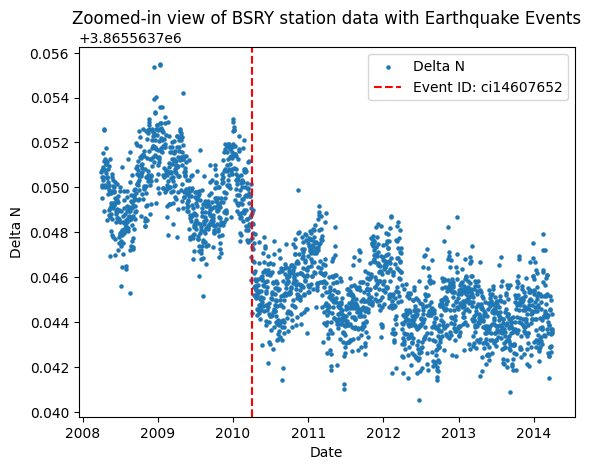

In [5]:
import matplotlib.pyplot as plt

# Define the date range for zooming in
start_date = '2008-04-01'  # Replace with actual start date
end_date = '2014-04-01'    # Replace with actual end date

# Filter the data within the date range
bsry_zoomed = bsry[(bsry['Date'] >= start_date) & (bsry['Date'] <= end_date)]

# Filter the DataFrame for earthquake events within the date range (non-empty Event ID)
earthquake_events = bsry_zoomed.dropna(subset=['Event ID'])

# Plot the zoomed-in data
plt.scatter(bsry_zoomed['Date'], bsry_zoomed['Delta N'], s=5, label='Delta N')

# Plot vertical lines at earthquake event dates
for _, event in earthquake_events.iterrows():
    plt.axvline(event['Date'], color='red', linestyle='--', label=f"Event ID: {event['Event ID']}")

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Delta N')
plt.title('Zoomed-in view of BSRY station data with Earthquake Events')
plt.legend(loc='best')

# Display the plot
plt.show()

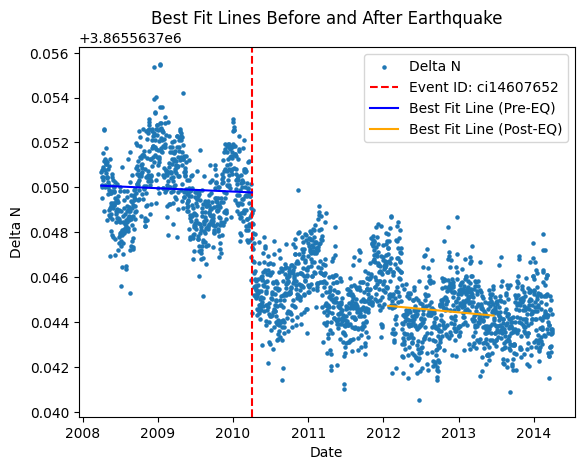

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define the date range for zooming in
start_date = '2008-04-01'
end_date = '2014-04-01'

# Filter the data within the date range
bsry_zoomed = bsry[(bsry['Date'] >= start_date) & (bsry['Date'] <= end_date)]

# Filter the DataFrame for earthquake events within the date range (non-empty Event ID)
earthquake_events = bsry_zoomed.dropna(subset=['Event ID'])

# Plot the zoomed-in data
plt.scatter(bsry_zoomed['Date'], bsry_zoomed['Delta N'], s=5, label='Delta N')

# Plot vertical lines at earthquake event dates
for _, event in earthquake_events.iterrows():
    plt.axvline(event['Date'], color='red', linestyle='--', label=f"Event ID: {event['Event ID']}")

# Fit a linear regression model to the pre-earthquake data
pre_eq_data = bsry_zoomed[bsry_zoomed['Date'] < earthquake_events.iloc[0]['Date']]
X_pre = np.array((pre_eq_data['Date'] - pre_eq_data['Date'].min()).dt.days).reshape(-1, 1)
y_pre = pre_eq_data['Delta N'].values

model_pre = LinearRegression().fit(X_pre, y_pre)
y_pre_pred = model_pre.predict(X_pre)

# Plot pre-earthquake best fit line
plt.plot(pre_eq_data['Date'], y_pre_pred, color='blue', label='Best Fit Line (Pre-EQ)')

# Find a matching slope in the post-earthquake data with adjustable window lengths
post_eq_data = bsry_zoomed[bsry_zoomed['Date'] > earthquake_events.iloc[0]['Date']]
tolerance = 1e-8  # Lower slope tolerance to find a closer match
slope_pre = model_pre.coef_[0]

# Initialize a variable to track whether a matching slope was found
matching_slope_found = False

# Start by trying with a smaller window and increase the window size
min_window_size = 30  # Minimum window size to start with
max_window_size = len(post_eq_data)  # Maximum window size (full dataset)

# Iterate over possible start points in the post-earthquake data
for start_idx in range(0, len(post_eq_data), min_window_size):  # Step by minimum window size
    # Vary window size from min_window_size to max_window_size
    for window_size in range(min_window_size, max_window_size - start_idx, 30):
        window_data = post_eq_data.iloc[start_idx:start_idx + window_size]
        if len(window_data) > 1:
            X_post = np.array((window_data['Date'] - pre_eq_data['Date'].min()).dt.days).reshape(-1, 1)
            y_post = window_data['Delta N'].values
            model_post = LinearRegression().fit(X_post, y_post)

            slope_post = model_post.coef_[0]

            if np.abs(slope_pre - slope_post) <= tolerance:
                # Once a match is found, extend the window and re-fit the model
                extended_window_data = post_eq_data.iloc[start_idx:start_idx + window_size + 120]  # Extend by 120 days
                X_extended_post = np.array((extended_window_data['Date'] - pre_eq_data['Date'].min()).dt.days).reshape(-1, 1)
                y_extended_post = extended_window_data['Delta N'].values
                
                # Re-fit the model on the extended data
                extended_model_post = LinearRegression().fit(X_extended_post, y_extended_post)
                y_extended_post_pred = extended_model_post.predict(X_extended_post)

                # Plot post-earthquake best fit line in orange, re-fitted on extended data
                plt.plot(extended_window_data['Date'], y_extended_post_pred, color='orange', label='Best Fit Line (Post-EQ)')
                matching_slope_found = True
                break
    if matching_slope_found:
        break

# If no matching slope was found, print a message
if not matching_slope_found:
    print("No matching slope found within the specified tolerance.")

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Delta N')
plt.title('Best Fit Lines Before and After Earthquake')
plt.legend(loc='best')

# Display the plot
plt.show()

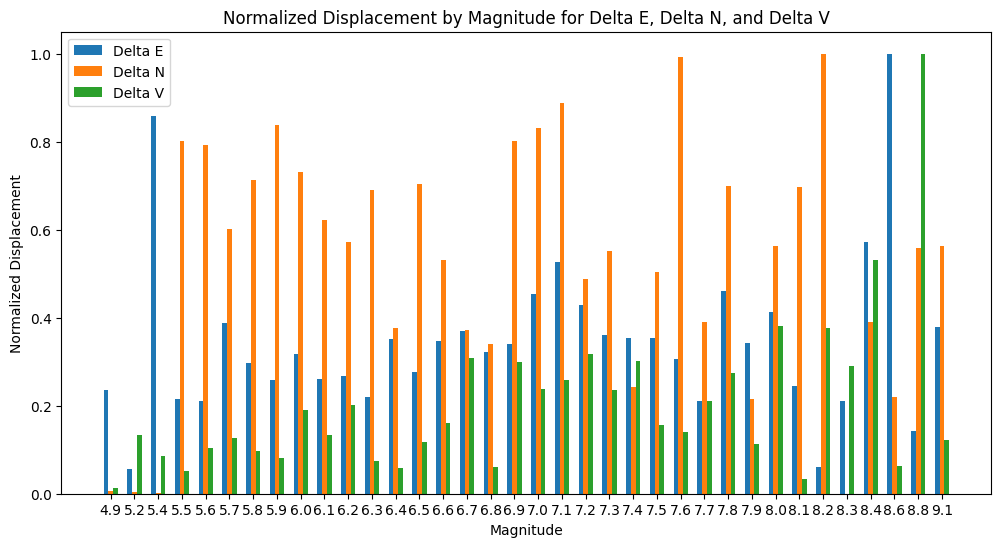

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize a list to store displacement data
displacement_data = []

# Loop through each unique event ID to calculate displacements
for event_id in main_df['Event ID'].dropna().unique():
    event_data = main_df[main_df['Event ID'] == event_id]
    
    # Ensure that we have data for the day before and after the event
    if len(event_data) >= 2:
        # Sort by date
        event_data_sorted = event_data.sort_values('Date')
        
        # Get the data for the day before and the day after the event
        day_before = event_data_sorted.iloc[0]  # First row, before the earthquake
        day_after = event_data_sorted.iloc[-1]  # Last row, after the earthquake
        
        # Calculate the displacement for each delta component
        delta_e_displacement = abs(day_after['Delta E'] - day_before['Delta E'])
        delta_n_displacement = abs(day_after['Delta N'] - day_before['Delta N'])
        delta_v_displacement = abs(day_after['Delta V'] - day_before['Delta V'])
        
        # Append displacement data along with the event magnitude
        displacement_data.append([day_after['Event Magnitude'], delta_e_displacement, delta_n_displacement, delta_v_displacement])

# Convert the displacement data into a DataFrame
displacement_df = pd.DataFrame(displacement_data, columns=['Magnitude', 'Delta E', 'Delta N', 'Delta V'])

# Group by Magnitude and calculate mean displacement for each component
displacement_grouped = displacement_df.groupby('Magnitude').mean().reset_index()

# Normalize the displacement values to a comparable scale
displacement_grouped[['Delta E', 'Delta N', 'Delta V']] = displacement_grouped[['Delta E', 'Delta N', 'Delta V']].apply(lambda x: x / x.max())

# Plotting the scaled displacement bar graph for each magnitude
fig, ax = plt.subplots(figsize=(12, 6))

# Set the positions for the bars
bar_width = 0.2
index = np.arange(len(displacement_grouped))

# Plot bars for Delta E, Delta N, and Delta V
ax.bar(index, displacement_grouped['Delta E'], bar_width, label='Delta E')
ax.bar(index + bar_width, displacement_grouped['Delta N'], bar_width, label='Delta N')
ax.bar(index + 2 * bar_width, displacement_grouped['Delta V'], bar_width, label='Delta V')

# Set labels and titles
ax.set_xlabel('Magnitude')
ax.set_ylabel('Normalized Displacement')
ax.set_title('Normalized Displacement by Magnitude for Delta E, Delta N, and Delta V')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(displacement_grouped['Magnitude'].round(2))
ax.legend()

# Display the plot
plt.show()